In [3]:
import pennylane as qml
from pennylane import numpy as np

Question 1 a) MVC problem as shown

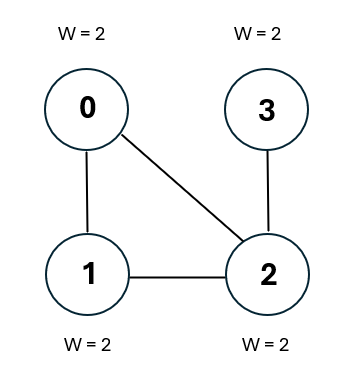

Question 1 b) Solutions are 0110 and 1010, selected vertex is represented by a blue colour fill

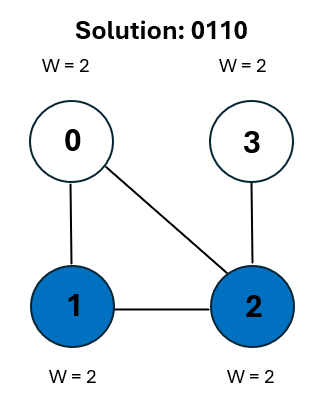

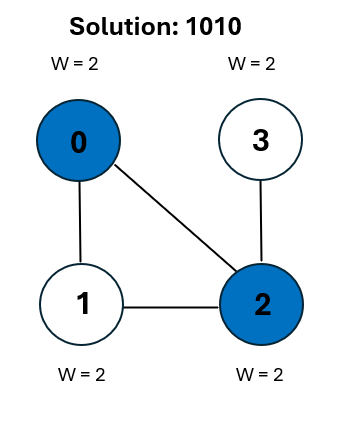

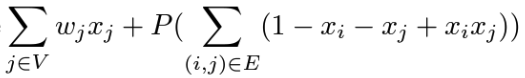

Question 1 c) H_Cost = 12 − 4*x_0 − 4*x_1 − 7*x_2 − x_3 + 3(x_0*x_1 + x_0*x_2 + x_1*x_2 + x_2*x_3)

Question 1 d) The linear terms in the Hamiltonian are defined in the U_B function, represented by RX gates acting on individual wires.

In [7]:
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)

The quadratic terms in the Hamiltonian are defined in the U_C function, represented by RZ and IsingZZ gates

In [8]:
def U_C(gamma):
    for edge in graph:
        wire1 = edge[0]
        wire2 = edge[1]
        qml.IsingZZ(gamma*P/2,wires=[wire1, wire2])
        qml.RZ(gamma*P/2, wires=wire2)
        qml.RZ(gamma*P/2, wires=wire1)
    for wire in range(n_wires):
        qml.RZ(-gamma*wts[wire],wires=wire)

Question 1 e) Dev1 is being used for the constant optimisation of the problem, whereas dev2 is returning the optimal solution for each stage in the optimisation. These processes are seperate as many steps are carried out in the optimisation, but the solution at each step is only needed to be calculate once, hence the difference in shot value for both devices.

Question 1 f) Extra vertex (4) with weight 2 added and joined to vertex 1. Steps changed to 100, shots changed to 2000, 3rd layer added. Changes to code are highlighted with a # note

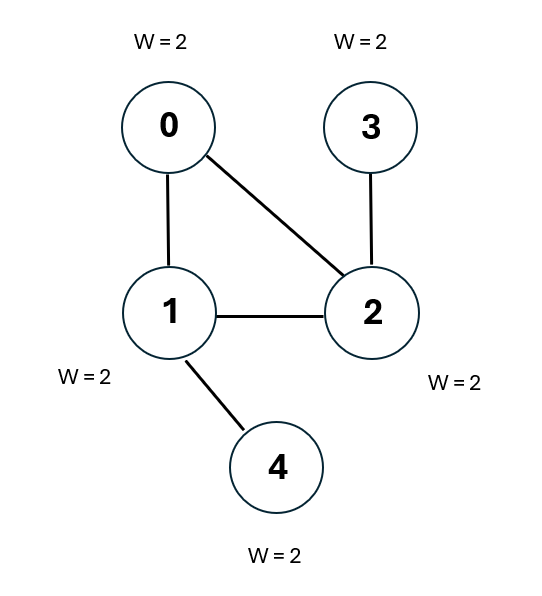

In [43]:
n_wires = 5 # Changed from 4 to 5
P=3 
wts=[2,2,2,2,2] # Extra weight added
graph=[(0, 1), (1, 2), (1, 4), (2, 0), (2, 3)] # Extra connection between vertex 1 and 4 added


def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)



def U_C(gamma):
    for edge in graph:
        wire1 = edge[0]
        wire2 = edge[1]
        qml.IsingZZ(gamma*P/2,wires=[wire1, wire2]) 
        qml.RZ(gamma*P/2, wires=wire2)
        qml.RZ(gamma*P/2, wires=wire1)
    for wire in range(n_wires):
        qml.RZ(-gamma*wts[wire],wires=wire)

In [44]:
def bitstring_to_int(bit_string_sample):
    bit_string = "".join(str(bs) for bs in bit_string_sample)
    return int(bit_string, base=2)

In [45]:
dev1 = qml.device("lightning.qubit", wires=n_wires, shots=1000) # Shots changed from 1000 to 2000 for increased accuracy
dev2 = qml.device("lightning.qubit", wires=n_wires, shots=1)

In [46]:
@qml.qnode(dev1)
def circuit1(gammas, betas, edge=None, n_layers=1):
  
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        
        return qml.sample()
 
    H = qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])
    return qml.expval(H)

In [47]:
@qml.qnode(dev2)
def circuit1s(gammas, betas, edge=None, n_layers=1):
    
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        
        return qml.sample()
    
    H = qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])
    return qml.expval(H)

In [48]:
@qml.qnode(dev1)
def circuit2(gammas, betas, wirep=None, n_layers=1):

    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
 
    H = qml.PauliZ(wirep)
    return qml.expval(H)

In [58]:
def qaoa_mvc(n_layers):
    print("\np={:d}".format(n_layers))

    
    init_params =  np.random.rand(2, n_layers, requires_grad=True) # initial parameters changed to deal with n_layer increase to 3
    
    print(init_params)

 
    def objective(params):
        gammas = params[0]
        betas = params[1]
        obj1 = 0
        obj2 = 0
        for edge in graph:
            obj1 += 0.25*P*circuit1(gammas, betas, edge=edge, n_layers=n_layers)
            obj1 += 0.25*P*circuit2(gammas, betas, wirep=edge[0], n_layers=n_layers)
            obj1 += 0.25*P*circuit2(gammas, betas, wirep=edge[1], n_layers=n_layers)
        for wire in range(n_wires):
            obj2 += -0.5*wts[wire]*circuit2(gammas, betas, wirep=wire, n_layers=n_layers)
        return obj1+obj2

    
    opt = qml.GradientDescentOptimizer()

 
    params = init_params
    steps = 100 # Steps changed from 70 to 100
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, objective(params)))


    bit_strings = []
    n_samples = 1000
    for i in range(0, n_samples):
        bit_strings.append(bitstring_to_int(circuit1s(params[0], params[1], edge=None, n_layers=n_layers)))
     

    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:05b}".format(most_freq_bit_string)) # Changed from :04b to :05b to deal with added vertex

    return objective(params), bit_strings

In [59]:
bitstrings1 = qaoa_mvc(n_layers=1)[1]
bitstrings2 = qaoa_mvc(n_layers=2)[1]
bitstrings3 = qaoa_mvc(n_layers=3)[1] # Added 3 layer run


p=1
[[0.47715738]
 [0.81325452]]
Objective after step     5: -0.2665000
Objective after step    10: -0.6760000
Objective after step    15: -0.6522500
Objective after step    20: -0.7407500
Objective after step    25: -0.5945000
Objective after step    30: -0.7155000
Objective after step    35: -0.6160000
Objective after step    40: -0.7407500
Objective after step    45: -0.6667500
Objective after step    50: -0.8640000
Objective after step    55: -0.7340000
Objective after step    60: -0.7285000
Objective after step    65: -0.5032500
Objective after step    70: -0.7107500
Objective after step    75: -0.7502500
Objective after step    80: -0.6880000
Objective after step    85: -0.7197500
Objective after step    90: -0.7655000
Objective after step    95: -0.6772500
Objective after step   100: -0.6735000
Optimized (gamma, beta) vectors:
[[0.93149925]
 [1.16903202]]
Most frequently sampled bit string is: 10011

p=2
[[0.37840431 0.49803071]
 [0.69862458 0.61882488]]
Objective after step   

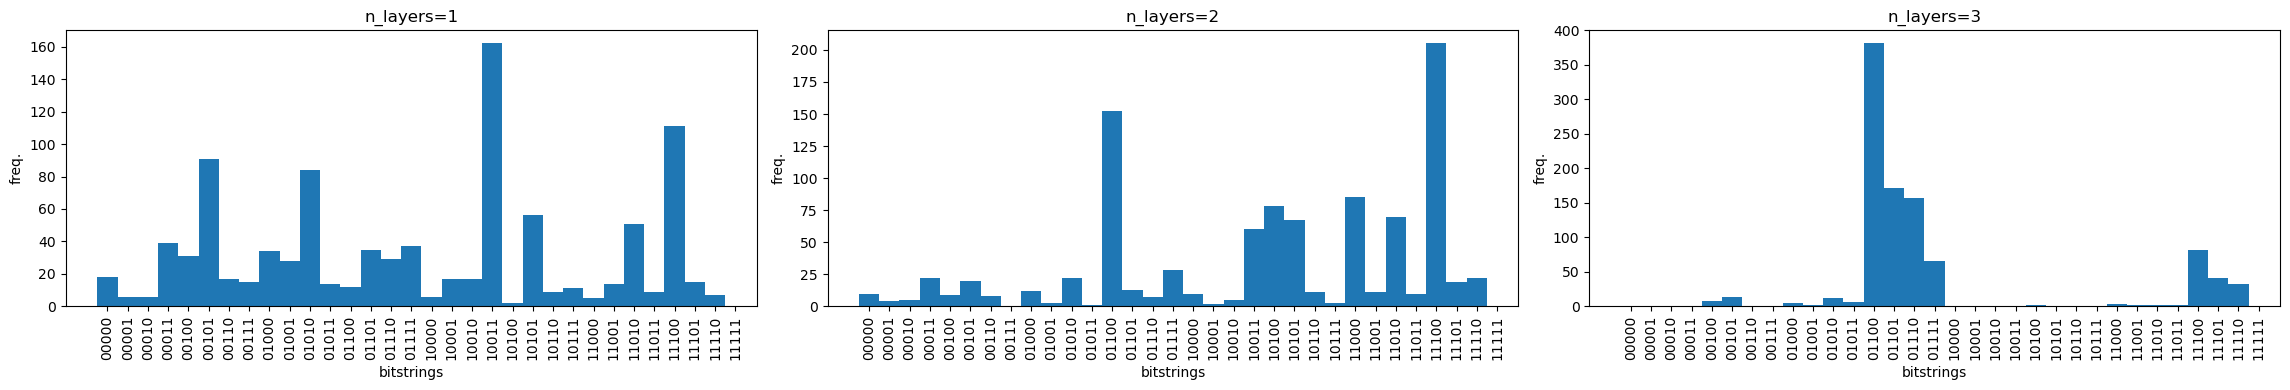

In [61]:
import matplotlib.pyplot as plt

xticks = range(0, 32) # Increased from 17 to 32 to account for added possible configurations
xtick_labels = list(map(lambda x: format(x, "05b"), xticks)) # "04b" changed to "05b" to account for added vertex
bins = np.arange(0, 32) - 0.5 # Increased from 17 to 32 to account for added possible configurations

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(23, 4))
plt.subplot(1, 3, 1)
plt.title("n_layers=1")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings1, bins=bins)
plt.subplot(1, 3, 2)
plt.title("n_layers=2")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings2, bins=bins)
plt.subplot(1, 3, 3)
plt.title("n_layers=3")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings3, bins=bins)
plt.tight_layout()
plt.show()

Solution found corresponds to ideal solution shown below. N_layers = 1 and 2 struggle to find the optimum solution but n_layer = 3 finds it much more than other solutions. n_layers = 3 is highly peaked around optimal solution for given paramaters.

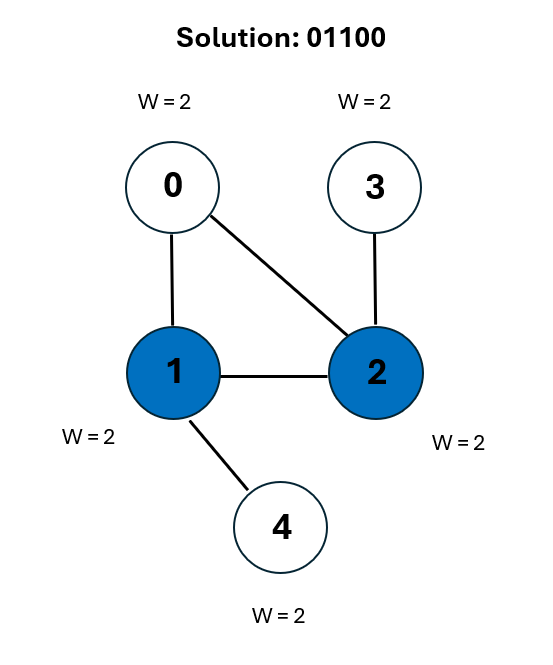